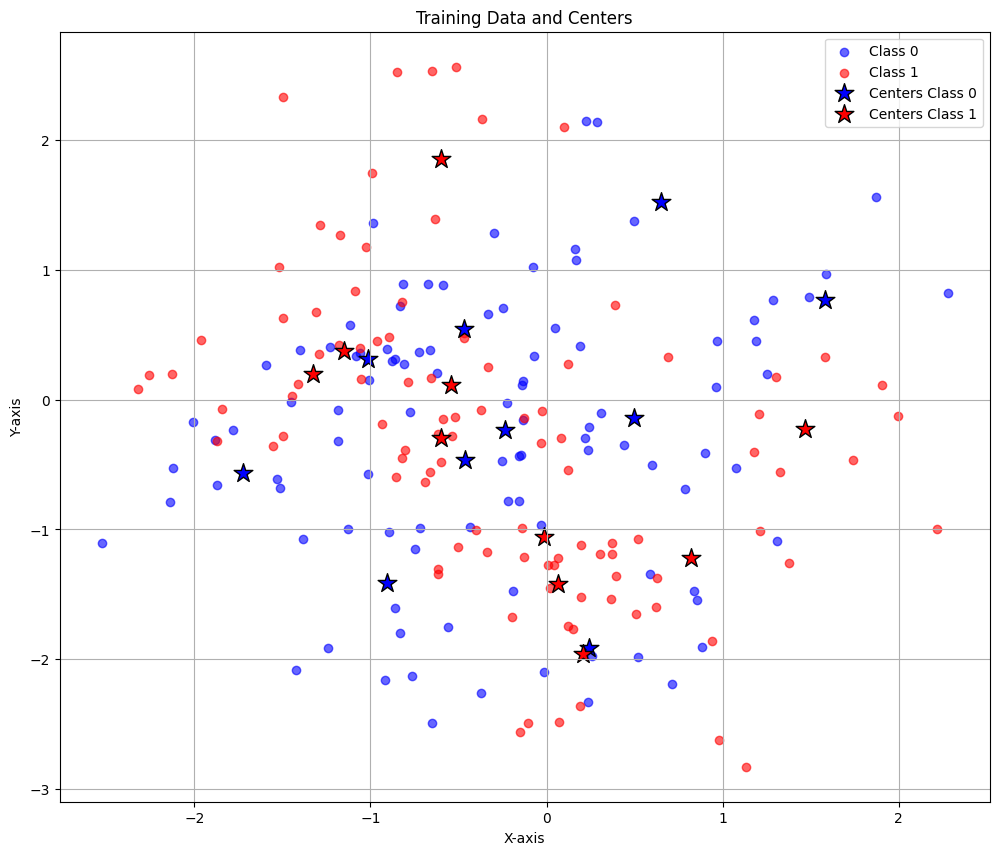

In [27]:
import numpy as np
import matplotlib.pyplot as plt

# Set random seed for reproducibility
#TODO: Add UIN to seed
np.random.seed(42)

# Constants
NUM_CLASSES = 2
CENTERS_PER_CLASS = 10
S2 = 1/5
TRAIN_SAMPLES_PER_CLASS = 100
TEST_SAMPLES_PER_CLASS = 5000

def generate_centers(mean=[0, 0], cov=[[1, 0], [0, 1]], total_centers=20):
    centers = np.random.multivariate_normal(mean=mean, cov=cov, size=total_centers)
    centers_class0 = centers[:CENTERS_PER_CLASS]
    centers_class1 = centers[CENTERS_PER_CLASS:]
    return centers_class0, centers_class1

def generate_data(centers, n_samples, s2=S2):
    # Randomly choose centers for each sample
    selected_centers = centers[np.random.choice(len(centers), n_samples)]
    
    # Generate samples from the selected centers
    noise = np.random.multivariate_normal(mean=[0, 0], cov=s2 * np.eye(2), size=n_samples)
    samples = selected_centers + noise
    
    # Assign labels based on the class
    # Assuming class_label is known externally
    return samples

def get_structured_data(class_0_centers, class_1_centers, n_test, n_train):
    
    # Generate training data
    train_samples_class0 = generate_data(class_0_centers, n_train)
    train_samples_class1 = generate_data(class_1_centers, n_train)

    # Generate test data
    test_samples_class0 = generate_data(class_0_centers, n_test)
    test_samples_class1 = generate_data(class_1_centers, n_test)

    # Create labels
    train_labels_class0 = np.zeros(n_train, dtype=int)
    train_labels_class1 = np.ones(n_train, dtype=int)
    test_labels_class0 = np.zeros(n_test, dtype=int)
    test_labels_class1 = np.ones(n_test, dtype=int)

    # Combine training data
    train_samples = np.vstack((train_samples_class0, train_samples_class1))
    train_labels = np.concatenate((train_labels_class0, train_labels_class1))

    # Combine test data
    test_samples = np.vstack((test_samples_class0, test_samples_class1))
    test_labels = np.concatenate((test_labels_class0, test_labels_class1))
    
    return train_samples, train_labels, test_samples, test_labels




# Generate 20 centers and split into two classes
centers_class0, centers_class1 = generate_centers()
centers = np.vstack((centers_class0, centers_class1))


train_samples, train_labels, test_samples, test_labels = get_structured_data(centers_class0, centers_class1, TEST_SAMPLES_PER_CLASS, TRAIN_SAMPLES_PER_CLASS)
train_samples_class0 = train_samples[train_labels == 0]
train_samples_class1 = train_samples[train_labels == 1]
test_samples_class0 = test_samples[test_labels == 0]
test_samples_class1 = test_samples[test_labels == 1]

# Plotting
plt.figure(figsize=(12, 10))

# Plot training samples
plt.scatter(train_samples_class0[:, 0], train_samples_class0[:, 1],
            c='blue', alpha=0.6, label='Class 0')
plt.scatter(train_samples_class1[:, 0], train_samples_class1[:, 1],
            c='red', alpha=0.6, label='Class 1')

# Overlay centers
plt.scatter(centers_class0[:, 0], centers_class0[:, 1],
            c='blue', marker='*', s=200, edgecolors='k', label='Centers Class 0')
plt.scatter(centers_class1[:, 0], centers_class1[:, 1],
            c='red', marker='*', s=200, edgecolors='k', label='Centers Class 1')

plt.title('Training Data and Centers')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend()
plt.grid(True)
plt.show()

# Checks
assert centers_class0.shape[0] == 10
assert centers_class1.shape[0] == 10
assert train_samples_class0.shape[0] == 100
assert train_samples_class1.shape[0] == 100
assert test_samples_class0.shape[0] == 5000
assert test_samples_class1.shape[0] == 5000


In [51]:
from sklearn.neighbors import KNeighborsClassifier

def confusion_matrix(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    TN = np.sum((y_true == 0) & (y_pred == 0))
    FP = np.sum((y_true == 0) & (y_pred == 1))
    FN = np.sum((y_true == 1) & (y_pred == 0))
    TP = np.sum((y_true == 1) & (y_pred == 1))
    
    cm = np.array([[TN, FP],
                   [FN, TP]])
    
    return cm

def accuracy_score(y_true, y_pred):    
    correct_predictions = np.sum(y_true == y_pred)
    accuracy = correct_predictions / len(y_true)
    
    return accuracy

# Part 2
def pairwise_distances(X, Y):
    X_squared = np.sum(X**2, axis=1, keepdims=True)
    Y_squared = np.sum(Y**2, axis=1)
    XY = np.dot(X, Y.T)
    squared_distances = X_squared + Y_squared - 2 * XY
    return np.sqrt(np.maximum(squared_distances, 0))

def knn(train_data, train_labels, test_data, k=3):
    assert train_data.shape[0] == train_labels.shape[0], "Mismatch in number of training samples and labels."
    assert train_data.shape[1] == test_data.shape[1], "Mismatch in number of features between training and test data."

    # Compute distances
    distances = pairwise_distances(test_data, train_data)
    assert distances.shape == (test_data.shape[0], train_data.shape[0]), "Incorrect shape of distance matrix."

    # Get indices of k nearest neighbors
    sorted_indices = np.argsort(distances, axis=1)[:, :k]
    assert sorted_indices.shape == (test_data.shape[0], k), "Incorrect shape of sorted indices."

    # Retrieve the labels of the k nearest neighbors
    nearest_labels = train_labels[sorted_indices]

    # Count the number of Class 1 neighbors
    class_1_counts = np.sum(nearest_labels, axis=1)

    # Determine predictions based on majority voting
    # If Class 1 count > k/2, predict Class 1; else, predict Class 0
    predictions = (class_1_counts > (k / 2)).astype(int)

    return predictions

def evaluate_knn(k_values, train_data, train_labels, test_data, test_labels):
    for k in k_values:
        print(f"\n=== Evaluating kNN with k={k} ===")

        # Custom kNN
        custom_preds = knn(train_data, train_labels, test_data, k=k)
        custom_cm = confusion_matrix(test_labels, custom_preds)
        custom_acc = accuracy_score(test_labels, custom_preds)
        print("Custom kNN Confusion Matrix:")
        print(custom_cm)
        print(f"Custom kNN Accuracy: {custom_acc:.4f}")

        # Scikit-learn kNN
        knn_sklearn = KNeighborsClassifier(n_neighbors=k)
        knn_sklearn.fit(train_data, train_labels)
        sklearn_preds = knn_sklearn.predict(test_data)
        sklearn_cm = confusion_matrix(test_labels, sklearn_preds)
        sklearn_acc = accuracy_score(test_labels, sklearn_preds)
        print("Scikit-learn kNN Confusion Matrix:")
        print(sklearn_cm)
        print(f"Scikit-learn kNN Accuracy: {sklearn_acc:.4f}")

        # Compare Predictions (Optional)
        # print(f"Prediction Match: {np.array_equal(custom_preds, sklearn_preds)}"))


K_VALUES = [1, 3, 5]
evaluate_knn(K_VALUES, train_samples, train_labels, test_samples, test_labels)




=== Evaluating kNN with k=1 ===
Custom kNN Confusion Matrix:
[[3204 1796]
 [2057 2943]]
Custom kNN Accuracy: 0.6147
Scikit-learn kNN Confusion Matrix:
[[3204 1796]
 [2057 2943]]
Scikit-learn kNN Accuracy: 0.6147

=== Evaluating kNN with k=3 ===
Custom kNN Confusion Matrix:
[[3255 1745]
 [1917 3083]]
Custom kNN Accuracy: 0.6338
Scikit-learn kNN Confusion Matrix:
[[3255 1745]
 [1917 3083]]
Scikit-learn kNN Accuracy: 0.6338

=== Evaluating kNN with k=5 ===
Custom kNN Confusion Matrix:
[[3364 1636]
 [2028 2972]]
Custom kNN Accuracy: 0.6336
Scikit-learn kNN Confusion Matrix:
[[3364 1636]
 [2028 2972]]
Scikit-learn kNN Accuracy: 0.6336


In [52]:
# Part 3
# TODO: How to know if this is right
from sklearn.model_selection import cross_val_score

def sklearn_cross_validation(X, y, k_fold, k_range=range(1, 181)):
    k_accuracies = {}
    
    for k in k_range:
        
        knn = KNeighborsClassifier(n_neighbors=k)
        
        scores = cross_val_score(knn, X, y, cv=k_fold, scoring='accuracy')
        k_accuracies[k] = scores.mean()
    
    # Select the largest k with the highest accuracy
    max_accuracy = max(k_accuracies.values())
    best_ks = [k for k, acc in k_accuracies.items() if acc == max_accuracy]
    best_k = max(best_ks)
    best_accuracy = k_accuracies[best_k]
    
    return best_k, best_accuracy, k_accuracies

def cross_validation_manual(X, y, k_fold, ks):
    n = len(X)
    print(n)
    fold_size = n // k_fold
    
    cv_err = np.zeros((len(ks), k_fold))
    for k_idx in range(len(ks)):

        for i in range(k_fold):
            start = i * fold_size
            end = (i + 1) * fold_size if i != k_fold - 1 else n
            X_train = np.concatenate([X[:start], X[end:]])
            y_train = np.concatenate([y[:start], y[end:]])
            assert len(X_train) == n - fold_size
            assert len(y_train) == n - fold_size
            X_val = X[start:end]
            y_val = y[start:end]

            assert len(X_val) == fold_size
            assert len(y_val) == fold_size

            knn = KNeighborsClassifier(n_neighbors=ks[k_idx])
            knn.fit(X_train, y_train)
            y_pred = knn.predict(X_val)
            cv_err[k_idx][i] = sum(y_pred != y_val)
    cv_err_mean = np.sum(cv_err, axis=1) / float(n)

    best_k_idx = np.argmin(cv_err_mean)
    print(best_k_idx)
    best_k = ks[best_k_idx]

    return best_k, cv_err_mean

# Perform cross-validation to find the best k
best_k, best_accuracy, k_accuracies = sklearn_cross_validation(train_samples, train_labels)

print(f"Best K: {best_k} with Cross-Validation Accuracy: {best_accuracy:.4f}")

best_k, errors = cross_validation_manual(train_samples, train_labels, 5, range(1, 181))
print(f"Best K: {best_k}")
print(errors)

# Train KNN with the best k on the entire training set
knn_best = KNeighborsClassifier(n_neighbors=best_k)
knn_best.fit(train_samples, train_labels)

# Predict on the test set
y_test_pred = knn_best.predict(test_samples)

# Generate confusion matrix
conf_matrix = confusion_matrix(test_labels, y_test_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Optionally, print accuracy on test data
test_accuracy = accuracy_score(test_labels, y_test_pred)
print(f"Test Accuracy: {test_accuracy:.4f}")

Best K: 1 with Cross-Validation Accuracy: 0.7200
200


ValueError: Expected n_neighbors <= n_samples_fit, but n_neighbors = 161, n_samples_fit = 160, n_samples = 40

In [9]:
# Part 4
from sklearn.naive_bayes import GaussianNB


def bayes_rule(X_test, centers, s2):
    n_samples, n_features = X_test.shape
    n_centers = centers.shape[0] // 2  # Assuming equal centers for each class
    
    # Reshape centers for broadcasting
    centers_reshaped = centers.reshape(2, n_centers, n_features)
    
    # Calculate squared Euclidean distances
    distances = np.sum((X_test[:, np.newaxis, np.newaxis, :] - centers_reshaped[np.newaxis, :, :, :]) ** 2, axis=3)
    
    # Calculate exponential terms
    exp_terms = np.exp(-distances / (2 * s2))
    
    # Sum over centers for each class
    class_probs = np.sum(exp_terms, axis=2)
    
    # Calculate the ratio
    ratio = class_probs[:, 1] / class_probs[:, 0]
    
    # Make predictions
    predictions = (ratio >= 1).astype(int)
    
    return predictions

# Test the function
y_pred = bayes_rule(test_samples, centers, 1/5)
conf_matrix = np.zeros((2, 2), dtype=int)
conf_matrix[0, 0] = np.sum((test_labels == 0) & (y_pred == 0))  # True Negatives
conf_matrix[0, 1] = np.sum((test_labels == 0) & (y_pred == 1))  # False Positives
conf_matrix[1, 0] = np.sum((test_labels == 1) & (y_pred == 0))  # False Negatives
conf_matrix[1, 1] = np.sum((test_labels == 1) & (y_pred == 1))  # True Positives

print("Confusion Matrix:")
print(conf_matrix)


clf = GaussianNB()
# For GaussianNB, we need training data. Since Bayes' rule implementation does not use training data,
# we'll use the same data as a simple validation (not recommended in practice).
# Ideally, you should have separate training and test sets.
clf.fit(test_samples, test_labels)
y_pred_sk = clf.predict(test_samples)
conf_matrix_sk = confusion_matrix(test_labels, y_pred_sk)
print("\nConfusion Matrix (GaussianNB):")
print(conf_matrix_sk)


Confusion Matrix:
[[3349 1651]
 [1344 3656]]

Confusion Matrix (GaussianNB):
[[3118 1882]
 [2604 2396]]


In [12]:
# Part 5
# Simulation study
def simulation_study(n_simulations, centers, train_size, test_size, s2, k_range):
    """
    Conducts a simulation study comparing kNN with fixed K, kNN with CV-selected K, and Bayes rule.

    Parameters:
    - n_simulations: int, number of simulations to run
    - centers: np.ndarray of shape (2 * n_centers, n_features)
    - train_size: int, number of training samples per simulation
    - test_size: int, number of test samples per simulation
    - s2: float, variance parameter for data generation
    - k_range: iterable, range of K values to try in cross-validation
    - random_state: int or None, seed for reproducibility

    Returns:
    - errors_knn7: list of float, error rates for kNN with K=7
    - errors_knn_cv: list of float, error rates for kNN with CV-selected K
    - errors_bayes: list of float, error rates for Bayes rule
    - selected_k_values: list of int, selected K values from cross-validation
    """
    errors_knn7 = []
    errors_knn_cv = []
    errors_bayes = []
    selected_k_values = []
    
    for sim in range(n_simulations):
        # Generate training data
        train_samples_class0 = generate_data(centers_class0, TRAIN_SAMPLES_PER_CLASS)
        train_samples_class1 = generate_data(centers_class1, TRAIN_SAMPLES_PER_CLASS)

        # Generate test data
        test_samples_class0 = generate_data(centers_class0, TEST_SAMPLES_PER_CLASS)
        test_samples_class1 = generate_data(centers_class1, TEST_SAMPLES_PER_CLASS)

        # Create labels
        train_labels_class0 = np.zeros(TRAIN_SAMPLES_PER_CLASS, dtype=int)
        train_labels_class1 = np.ones(TRAIN_SAMPLES_PER_CLASS, dtype=int)
        test_labels_class0 = np.zeros(TEST_SAMPLES_PER_CLASS, dtype=int)
        test_labels_class1 = np.ones(TEST_SAMPLES_PER_CLASS, dtype=int)
        
        # kNN with K=7
        knn7 = KNeighborsClassifier(n_neighbors=7)
        knn7.fit(X_train, y_train)
        y_pred_knn7 = knn7.predict(X_test)
        error_knn7 = 1 - accuracy_score(y_test, y_pred_knn7)
        errors_knn7.append(error_knn7)
        
        # kNN with CV-selected K
        best_k, _ = cross_validation_knn(X_train, y_train, k_range=k_range, cv_folds=10, random_state=sim_seed)
        selected_k_values.append(best_k)
        knn_cv_best = KNeighborsClassifier(n_neighbors=best_k)
        knn_cv_best.fit(X_train, y_train)
        y_pred_knn_cv = knn_cv_best.predict(X_test)
        error_knn_cv = 1 - accuracy_score(y_test, y_pred_knn_cv)
        errors_knn_cv.append(error_knn_cv)
        
        # Bayes rule
        y_pred_bayes = bayes_rule(X_test, centers, s2)
        error_bayes = 1 - accuracy_score(y_test, y_pred_bayes)
        errors_bayes.append(error_bayes)
        
        # Optional: Print progress
        if (sim + 1) % 10 == 0:
            print(f"Completed {sim + 1}/{n_simulations} simulations.")
    
    return errors_knn7, errors_knn_cv, errors_bayes, selected_k_values

def plot_error_boxplot(errors_knn7, errors_knn_cv, errors_bayes):
    """
    Plots a boxplot comparing error rates of different classification methods.

    Parameters:
    - errors_knn7: list of float, error rates for kNN with K=7
    - errors_knn_cv: list of float, error rates for kNN with CV-selected K
    - errors_bayes: list of float, error rates for Bayes rule
    """
    plt.figure(figsize=(12, 8))
    plt.boxplot([errors_knn7, errors_knn_cv, errors_bayes], labels=['kNN (K=7)', 'kNN (CV)', 'Bayes Rule'], patch_artist=True,
                boxprops=dict(facecolor='lightblue', color='blue'),
                medianprops=dict(color='red'),
                whiskerprops=dict(color='blue'),
                capprops=dict(color='blue'),
                flierprops=dict(color='blue', markeredgecolor='blue'))
    plt.title('Test Error Rates for Different Classification Methods')
    plt.ylabel('Error Rate')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

def report_five_number_summary(selected_k_values):
    """
    Reports the five-number summary for selected K values.

    Parameters:
    - selected_k_values: list of int, selected K values from cross-validation

    Returns:
    - summary: dict, containing min, 25%, median, 75%, and max
    """
    summary = {
        'Min': np.min(selected_k_values),
        '25%': np.percentile(selected_k_values, 25),
        'Median': np.median(selected_k_values),
        '75%': np.percentile(selected_k_values, 75),
        'Max': np.max(selected_k_values)
    }
    return summary


n_simulations = 50
train

# Run simulation study
errors_knn7, errors_knn_cv, errors_bayes, selected_k_values = simulation_study(
    n_simulations=n_simulations,
    centers=centers,
    train_size=train_size,
    test_size=test_size,
    s2=s2,
    k_range=k_range,
    random_state=RANDOM_STATE
)

# Plot boxplot of error rates
plot_error_boxplot(errors_knn7, errors_knn_cv, errors_bayes)

# Calculate and print five-number summary for selected K values
k_summary = report_five_number_summary(selected_k_values)
print("\nFive-number summary for selected K values:")
for key, value in k_summary.items():
    print(f"{key}: {value}")

# Optional: Display summary statistics for error rates
    def display_error_summary(errors, method_name):
        summary = {
            'Min': np.min(errors),
            '25%': np.percentile(errors, 25),
            'Median': np.median(errors),
            '75%': np.percentile(errors, 75),
            'Max': np.max(errors)
        }
        print(f"\nFive-number summary for {method_name}:")
        for key, value in summary.items():
            print(f"{key}: {value}")
    
    display_error_summary(errors_knn7, 'kNN (K=7)')
    display_error_summary(errors_knn_cv, 'kNN (CV)')
    display_error_summary(errors_bayes, 'Bayes Rule')

NameError: name 'train' is not defined